In [2]:
# Preprocessing
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

fake_df = pd.read_csv("../data/Fake.csv")
true_df = pd.read_csv("../data/True.csv")

# create new column that combines title and text together called title_text_combined
true_df['title_text_combined'] = true_df['title'] + " " + true_df['text']
# add response column and set to 1 for true dataset
true_df["response"] = 1

# create new column that combines title and text together called title_text_combined
fake_df['title_text_combined'] = fake_df['title'] + " " + fake_df['text']
# add response column and set to 1 for true dataset
fake_df["response"] = 0

# remove title, text, subject and date columns
fake_df.drop(["title", "text", "subject","date"],axis = 1,inplace = True)
true_df.drop(["title", "text", "subject","date"],axis = 1,inplace = True)

# convert all text to lowercase
fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:x.lower())
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:x.lower())

# tokenization - this may take a while...
fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:word_tokenize(x))
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:word_tokenize(x))

# removing punctuation
import string
fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:[wrd for wrd in x if wrd not in string.punctuation])
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:[wrd for wrd in x if wrd not in string.punctuation])

# removing stopwords
stop_words = set(stopwords.words('english'))

fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:[wrd for wrd in x if wrd not in stop_words])
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:[wrd for wrd in x if wrd not in stop_words])

from nltk.stem.porter import *
# stemming of words
stemmer = PorterStemmer()
fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:[stemmer.stem(wrd) for wrd in x])
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:[stemmer.stem(wrd) for wrd in x])

# remove any empty tokens from both fake_df and true_df
fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:[wrd for wrd in x if wrd != ''])
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:[wrd for wrd in x if wrd != ''])

# lemmitization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
fake_df['title_text_combined'] = fake_df['title_text_combined'].apply(lambda x:[lemmatizer.lemmatize(wrd) for wrd in x])
true_df['title_text_combined'] = true_df['title_text_combined'].apply(lambda x:[lemmatizer.lemmatize(wrd) for wrd in x])

# merging fake and true dataframes together
merged_df = pd.concat([true_df, fake_df], ignore_index=True)

X = merged_df['title_text_combined'].values
Y = merged_df['response'].values

# start splitting data into test and train sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=42)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

# Tokenize the text data
max_words = 10000  #  Maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weede\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# RNN-Bidirectional LSTM

import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

embedding_dim = 50

# length of the longest sentence in dataset
max_length = 500

# To fit the data into any neural network, we need to convert the data into sequence matrices
x_train_padded = sequence.pad_sequences(x_train_tokens,maxlen=max_length,padding='post')
x_test_padded = sequence.pad_sequences(x_test_tokens,maxlen=max_length,padding='post')

# Define model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(x_train_padded, y_train, epochs=10, validation_split=0.2)

# Evaluate model
test_loss, test_acc = model.evaluate(x_test_padded, y_test)
print('Test Accuracy:', test_acc)

Epoch 1/10
898/898 [==============================] - 318s 348ms/step - loss: 0.0722 - accuracy: 0.9733 - val_loss: 0.0171 - val_accuracy: 0.9935
Epoch 2/10
898/898 [==============================] - 296s 330ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.0091 - val_accuracy: 0.9969
Epoch 3/10
898/898 [==============================] - 298s 332ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0124 - val_accuracy: 0.9953
Epoch 4/10
898/898 [==============================] - 301s 335ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0120 - val_accuracy: 0.9958
Epoch 5/10
898/898 [==============================] - 307s 342ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0104 - val_accuracy: 0.9964
Epoch 6/10
898/898 [==============================] - 302s 337ms/step - loss: 5.3062e-04 - accuracy: 0.9999 - val_loss: 0.0091 - val_accuracy: 0.9974
Epoch 7/10
898/898 [==============================] - 304s 339ms/step - loss: 4.0966e-04 - accuracy: 1.0000 - val_loss: 

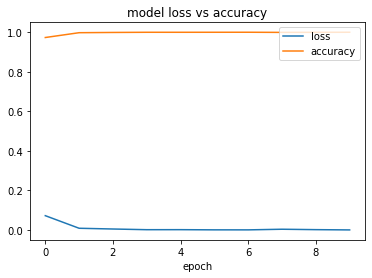

In [4]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()